<a href="https://www.einstein.br/"> <img src="albert-einstein.svg" alt="Header" style="width: 300px;"/> </a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import pandas_profiling as pp
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, plot_confusion_matrix

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import OneSidedSelection

### Data preprocessing

In [2]:
# Load data
df_data = pd.read_csv('df_data.csv')

# Base has 10,000 lines and 4 columns
df_data.shape

(10000, 4)

<AxesSubplot:>

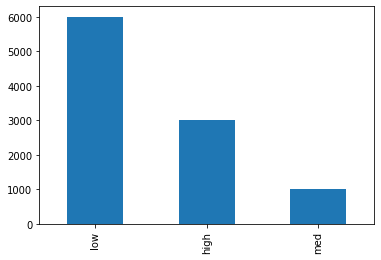

In [3]:
# Number of classes and number of examples
# Unbalanced base
df_data['target'].value_counts().plot.bar()

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      10000 non-null  float64
 1   x2      10000 non-null  float64
 2   x3      10000 non-null  float64
 3   target  10000 non-null  object 
dtypes: float64(3), object(1)
memory usage: 312.6+ KB


In [5]:
# No null values
df_data.isna().sum()

x1        0
x2        0
x3        0
target    0
dtype: int64

<AxesSubplot:>

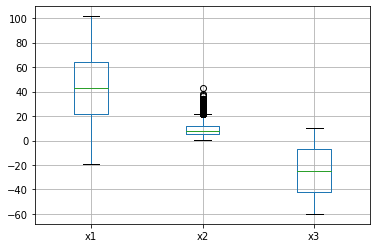

In [6]:
df_data.boxplot()

In [7]:
# Remove outliers from the base in x2, when observed by the boxplot

for i in df_data.columns[:-1]:
    Q1 = df_data[i].quantile(0.25)
    Q3 = df_data[i].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 

    filter = (df_data[i] >= Q1 - 1.5 * IQR) & (df_data[i] <= Q3 + 1.5 *IQR)
    df_data = df_data.loc[filter]

In [8]:
# StandardScaler
# Normalization of the base to values on the same scale.
# Algorithm understands that features have the same importance.

scaler = StandardScaler()
y = df_data['target'].values
df_data = pd.DataFrame(scaler.fit_transform(df_data.iloc[:,:-1]))
df_data.columns = ['x1', 'x2', 'x3']
df_data['target'] = y

<AxesSubplot:>

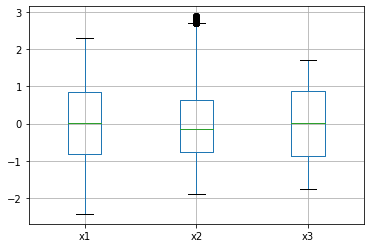

In [9]:
df_data.boxplot()

### 3D data visualization

In [10]:
l = []
for i in df_data['target'].values:
    if i=='high':
        l.append('red')
    elif i=='low':
        l.append('blue')
    else:
        l.append('black')

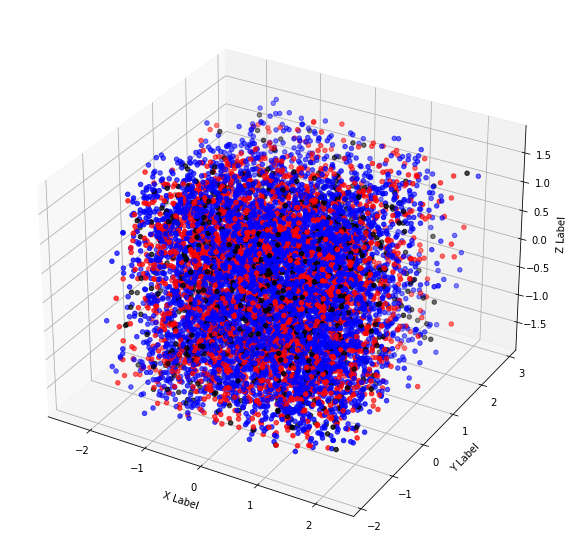

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

x = df_data['x1']
y = df_data['x2']
z = df_data['x3']

ax.scatter(x, y, z, c=l, marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [263]:
# Exploratory analysis with pandas profiling
# Uniform distribution of data in the variable x3, shown by the histogram

profile = pp.ProfileReport(df_data, title="Pandas Profiling Report")

In [264]:
profile.to_notebook_iframe()

### Unbalanced base - Overlapping data

In [12]:
# Remove x3 column: uniform histogram
# Tests were performed with features x1 and x2

df_data = df_data[['x1', 'x2', 'target']]

In [1749]:
# Remove x3 and x1 column
# Tests were performed with feature x2

df_data = df_data[['x2', 'target']]

In [13]:
# Division of features and labels

X = df_data.drop('target', axis=1)
y = df_data['target']

In [14]:
# SMOTE is an oversampling technique combined with the Edited Nearest Neighbors (undersampling technique)

sme = SMOTEENN(sampling_strategy='all', random_state=42)
df_data, y_res = sme.fit_resample(X, y)
df_data['target'] = y_res

In [15]:
X = df_data.drop('target', axis=1)
y = df_data['target']

In [16]:
# One-Sided Selection is an undersampling technique that combines Tomek Links and the Condensed Nearest Neighbor
# Tomek links are used as an undersampling method and removes noisy and borderline majority class examples
# CNN aims to remove examples from the majority class that are distant from the decision border

sme = OneSidedSelection(sampling_strategy='auto')
df_data, y_res = sme.fit_resample(X, y)
df_data['target'] = y_res

In [20]:
df_data['target'].value_counts()

med     2239
high    1456
low      786
Name: target, dtype: int64

<AxesSubplot:xlabel='x1', ylabel='x2'>

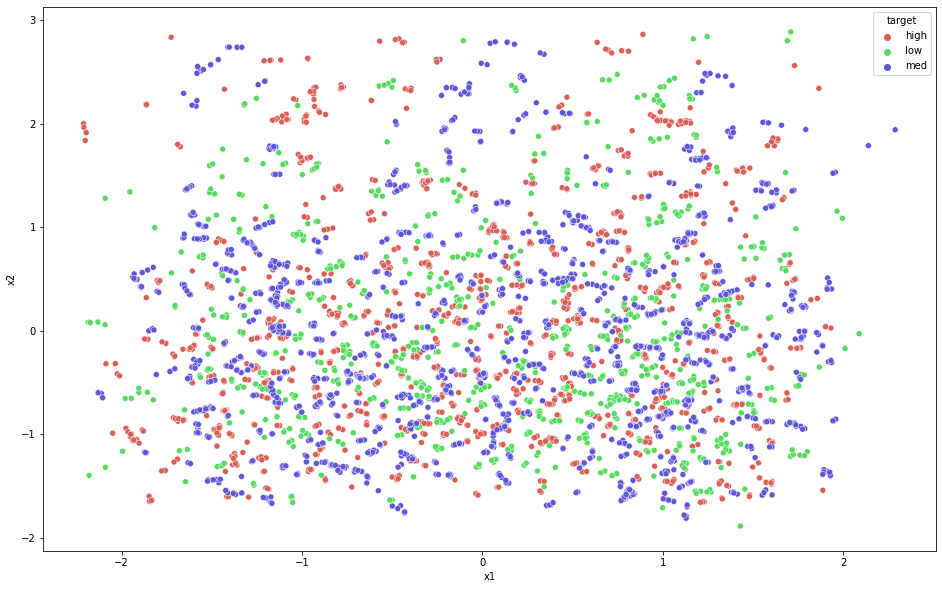

In [18]:
# 2D data visualization for x1 and x2 variables

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x1", y="x2",
    hue="target",
    palette=sns.color_palette("hls", len(set(df_data['target']))),
    data=df_data,
    legend="full"
)

In [21]:
# Division of features and labels to train

X = df_data.drop('target', axis=1)
y = df_data['target']

In [22]:
# Data split
# Training 70% and test 30% in a stratified way, to minimize the problem of unbalanced data.

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=42)

### KNN

The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these.

In [41]:
# Cross validation
knn = KNeighborsClassifier(n_neighbors=1)
scores = cross_validate(knn, X, y, scoring='accuracy', cv=10, return_train_score=True, n_jobs=-1)

In [42]:
# Test score
scores_train = abs(scores['train_score'])
scores_test = abs(scores['test_score'])
print('train: ', np.mean(scores_train))
print('test: ', np.mean(scores_test))

train:  1.0
test:  0.956257457047407


In [43]:
# Train
knn.fit(X_train, y_train)
# Predict
y_pred = knn.predict(X_test)

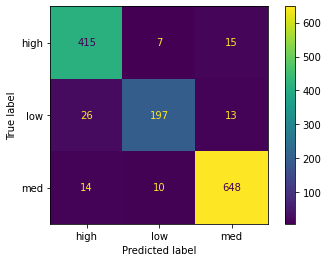

In [44]:
# KNN [x1, x2]
# Confusion matrix shows the amount of testing that the model predicted correctly or not.
# high: 415 are correct, but 7 (low) and 15 (med) was predicted wrong
# low: 197 are correct, but 26 (high) and 13 (med) was predicted wrong
# med: 648 are correct, but 14 (high) and 10 (low) was predicted wrong

plot_confusion_matrix(knn, X_test, y_test)
plt.show()

In [27]:
# Classification report

# The f1-score gives you the harmonic mean of precision and recall.

# The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points
# in that particular class compared to all other classes.

# The support is the number of samples of the true response that lie in that class.

# Accuracy is the proximity of measurement results to the true value.

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.91      0.95      0.93       437
         low       0.92      0.83      0.88       236
         med       0.96      0.96      0.96       672

    accuracy                           0.94      1345
   macro avg       0.93      0.92      0.92      1345
weighted avg       0.94      0.94      0.94      1345



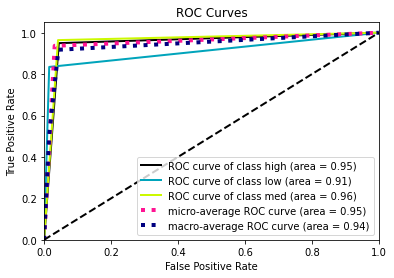

In [28]:
# ROC curve is a graphical plot that illustrates the performance of a classifier.

predicted_probas = knn.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, predicted_probas)
plt.show()

### KNN analysis

In [31]:
error = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

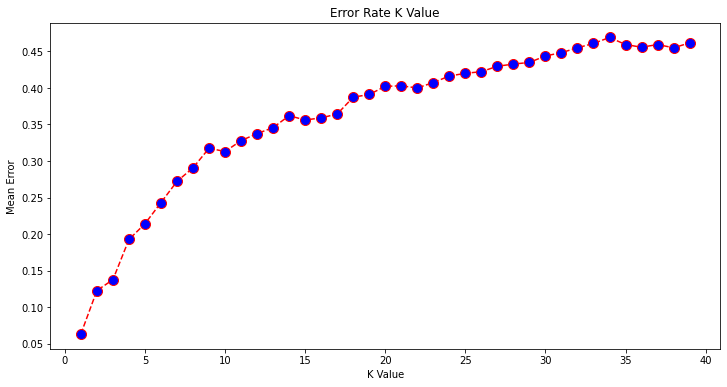

In [32]:
# smaller Mean Error K=1
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

### Decision Tree

Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

In [33]:
# Cross validation
classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
scores = cross_validate(classifier, X, y, scoring='accuracy', cv=10, return_train_score=True, n_jobs=-1)

In [34]:
# Test score
scores_train = abs(scores['train_score'])
scores_test = abs(scores['test_score'])
print('train: ', np.mean(scores_train))
print('test: ', np.mean(scores_test))

train:  1.0
test:  0.870565542475342


In [35]:
# Train
classifier.fit(X_train, y_train)
# Predict
y_pred = classifier.predict(X_test)

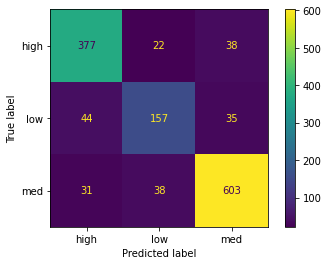

In [36]:
# Decision Tree [x1, x2]
# Confusion matrix shows the amount of testing that the model predicted correctly or not.
# high: 377 are correct, but 22 (low) and 38 (med) was predicted wrong
# low: 157 are correct, but 44 (high) and 35 (med) was predicted wrong
# med: 603 are correct, but 31 (high) and 38 (low) was predicted wrong

plot_confusion_matrix(classifier, X_test, y_test)  
plt.show()

In [37]:
# Classification report

# The f1-score gives you the harmonic mean of precision and recall.

# The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points
# in that particular class compared to all other classes.

# The support is the number of samples of the true response that lie in that class.

# Accuracy is the proximity of measurement results to the true value.

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        high       0.83      0.86      0.85       437
         low       0.72      0.67      0.69       236
         med       0.89      0.90      0.89       672

    accuracy                           0.85      1345
   macro avg       0.82      0.81      0.81      1345
weighted avg       0.84      0.85      0.84      1345



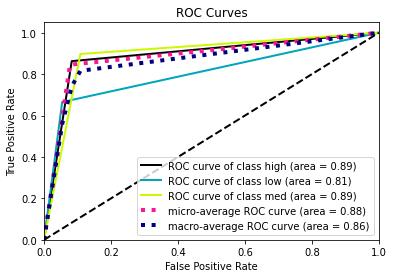

In [38]:
# ROC curve is a graphical plot that illustrates the performance of a classifier.

predicted_probas = classifier.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, predicted_probas)
plt.show()

# Results

Data does not have a well-defined separation region, so these algorithms do not have a good result, as they are based on separation regions.

MultiLayer Perceptron (based on class separation by the activation function)\
Logistic Regression (based on separation of classes by the logistic function)\
Support Vector Machine (based on class separation by rbf kernel)

**KNN** and **Decision Tree** were chosen.

**KNN** because it is based on the neighborhood of the data, so we can have several neighborhoods.\
**Decision Tree** is based on decision rules, each rule can occupy a different space in the data.

## **KNN**

**x1, x2**

              precision    recall  f1-score   support

        high       0.91      0.95      0.93       437
         low       0.92      0.83      0.88       236
         med       0.96      0.96      0.96       672

    accuracy                           0.94      1345


**x2**

              precision    recall  f1-score   support

        high       0.95      0.97      0.96       236
         low       0.96      0.99      0.98       373
         med       0.99      0.96      0.97       403

    accuracy                           0.97      1012

According to the results shown above, we can see that the variable **x2** is more important to classify the classes, as it obtained an accuracy of **0.97**.\
When **x1** and **x2** are combined, the accuracy was **0.94**, so **x1** is less important in the model.

## **Decision Tree**

**x1, x2**

              precision    recall  f1-score   support

        high       0.83      0.86      0.85       437
         low       0.72      0.67      0.69       236
         med       0.89      0.90      0.89       672

    accuracy                           0.85      1345


**x2**

              precision    recall  f1-score   support

        high       0.95      0.97      0.96       236
         low       0.96      0.99      0.98       373
         med       0.99      0.96      0.97       403

    accuracy                           0.97      1012

According to the results shown above, we can see that the variable **x2** is more important to classify the classes, as it obtained an accuracy of **0.97**.\
When **x1** and **x2** are combined, the accuracy was **0.85**, so **x1** is less important in the model.

The variable **x2** has a strong characteristic for classifying classes, in KNN and Decision Tree.